                                                     **Sinking of Titanic**
![Image of Titanic](http://www.titanicuniverse.com/wp-content/uploads/2009/12/titanic-disaster-300x244.jpg)


The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Do a complete analysis on what sorts of people were likely to survive. 

In [1]:
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

# import libraries for model validation
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
df_train = pd.read_csv("train.csv")
df_train.shape

(891, 12)

In [3]:
# see distinct values in the Sex column
df_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [4]:
# see distinct values in the Sex column
df_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [5]:
# see distinct values in the Embarked column
df_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
# Checking for missing values
# It's easy to check for missing values by calling the isnull() method, and 
# the sum() method off of that, to return a tally of all the True values that are returned 
# by the isnull() method.

df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df_train.shape

(891, 12)

In [8]:
# there are only 891 rows in the titanic data frame. Cabin is almost all missing values, 
# so we can drop that variable completely, 

# but what about age? 
# Age seems like a relevant predictor for survival right? We'd want to keep the variables, 
# but it has 177 missing values.  

# Need to find a way to approximate for those missing values!

In [9]:
# drop all the variables that aren't relevant for predicting survival. 
# We should at least keep the following:

# Survived - This variable is obviously relevant.
# Pclass   - Does a passenger's class on the boat affect their survivability?
# Sex      - Could a passenger's gender impact their survival rate?
# Age      - Does a person's age impact their survival rate?
# SibSp    - Does the number of relatives on the boat (that are siblings or a spouse) 
#            affect a person survivability? Probability
# Parch    - Does the number of relatives on the boat (that are children or parents) 
#            affect a person survivability? Probability
# Fare     - Does the fare a person paid effect his survivability? Maybe - let's keep it.
# Embarked - Does a person's point of embarkation matter? 
#            It depends on how the boat was filled... Let's keep it.

In [10]:
# What about a person's name, ticket number, and passenger ID number? 
# They're irrelavant for predicting survivability. 
# And as you recall, the cabin variable is almost all missing values, 
# so we can just drop all of these.

In [11]:
df_train = df_train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [12]:
# now we need to deal with the missing values in the age variable.

# Speaking roughly, we could say that the younger a passenger is, the more likely it is for them 
# to be in 3rd class. The older a passenger is, the more likely it is for them to be in 1st class. So there is a loose relationship between these variables. So, let's write a function that approximates a passengers age, based on their class. From the box plot, it looks like the average age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

# find each null value in the Age variable and for each null, checks the value of the Pclass 
# and assigns an age value according to the average age of passengers in that class.

def age_approx(cols):
    Age    = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [13]:
# avg age per class
# df_train[df_train['Pclass']== 1]['Age'].mean()
# df_train[df_train['Pclass']== 2]['Age'].mean()
# df_train[df_train['Pclass']== 3]['Age'].mean()

In [14]:
df_train.groupby(['Pclass']).mean()


,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,
1,0.629630,38.233441,0.416667,0.356481,84.154687
2,0.472826,29.877630,0.402174,0.380435,20.662183
3,0.242363,25.140620,0.615071,0.393075,13.675550


In [15]:
df_train['Age'] = df_train[['Age', 'Pclass']].apply(age_approx, axis=1)

In [16]:
# check for null again
df_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [17]:
# There are 2 null values in the embarked variable. We can drop those 2 records without 
# loosing too much important information from our dataset, so we will do that.

In [18]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [19]:
# Converting categorical variables to a dummy indicators ************************

In [20]:
# object signifies they are of categorical/string type data
df_train.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [21]:
#pd.get_dummies(df_train['Sex'], drop_first=True)
df_train_dummied = pd.get_dummies(df_train, columns=["Sex"])

In [22]:
df_train_dummied = pd.get_dummies(df_train_dummied, columns=["Embarked"])

In [23]:
df_train_dummied.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


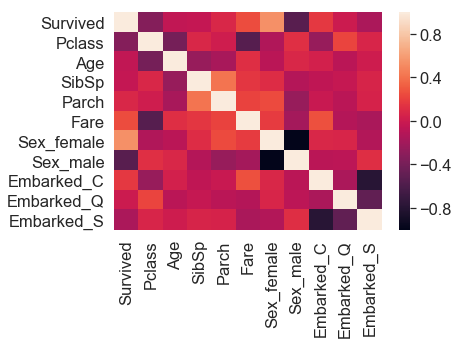

In [24]:
# Checking for independence between features
plt.figure(figsize=(6,4))
sns.heatmap(df_train_dummied.corr())  

In [25]:
used_features =[
    "Pclass",
    "Age",
    "SibSp",
    "Parch",
    "Sex_female",
    "Sex_male",
    "Embarked_C",
    "Embarked_Q",
    "Embarked_S"
]

X = df_train_dummied[used_features].values
y = df_train_dummied['Survived']

In [26]:
# Split dataset in training and test datasets
# X_train, X_test = train_test_split(df_train, test_size=0.5, random_state=int(time.time()))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(622, 9)
(267, 9)
(622,)
(267,)


In [32]:
# Instantiate the classifier
svc = SVC()


In [34]:
# Train classifier
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

C:\Users\Nihal\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [36]:
metrics.confusion_matrix(y_test, y_pred)

array([[148,  13],
       [ 29,  77]], dtype=int64)

In [37]:
metrics.accuracy_score(y_test, y_pred)

0.8426966292134831

In [38]:
len(X_test)

267

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       161
           1       0.86      0.73      0.79       106

   micro avg       0.84      0.84      0.84       267
   macro avg       0.85      0.82      0.83       267
weighted avg       0.84      0.84      0.84       267



In [41]:
df_train_dummied[used_features].columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')